In [66]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor
from typing import Dict, Any, Tuple, Optional, List
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from dataclasses import dataclass
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import logging

plt.style.use('dark_background')
np.random.seed(1000000000)


In [67]:
df = pd.read_csv('_data/ingatlan.csv')
df.head()


,county,city,postcode,property_type,property_subtype,property_condition_type,property_floor,building_floor_count,view_type,orientation,...,room_cnt,small_room_cnt,created_at,property_area,balcony_area,price_created_at,ad_view_cnt,active_days,nr,district
0,Budapest,Budapest IV.,NaN,flat,prefabricated panel flat (for sale),good,3,10,garden view,east,...,1.0,1.0,2015-02-09,35.0,0.0,9.5,702.0,23.0,7,4.0
1,Budapest,Budapest XIV.,1147.0,flat,brick flat (for sale),novel,ground floor,NaN,NaN,NaN,...,1.0,0.0,2015-02-09,35.0,0.0,11.2,42.0,6.0,8,14.0
2,Budapest,Budapest XIV.,NaN,flat,brick flat (for sale),medium,4,NaN,NaN,NaN,...,2.0,0.0,2015-02-09,50.0,0.0,14.5,504.0,96.0,9,14.0
3,Budapest,Budapest II.,1024.0,flat,brick flat (for sale),novel,basement,NaN,street view,NaN,...,1.0,1.0,2015-02-09,50.0,0.0,15.3,39.0,1.0,11,2.0
4,Budapest,Budapest XII.,1126.0,flat,brick flat (for sale),good,ground floor,NaN,garden view,NaN,...,1.0,2.0,2015-02-09,50.0,0.0,17.9,114.0,27.0,13,12.0


In [68]:
df.columns


Index(['county', 'city', 'postcode', 'property_type', 'property_subtype',
       'property_condition_type', 'property_floor', 'building_floor_count',
       'view_type', 'orientation', 'garden_access', 'heating_type',
       'elevator_type', 'room_cnt', 'small_room_cnt', 'created_at',
       'property_area', 'balcony_area', 'price_created_at', 'ad_view_cnt',
       'active_days', 'nr', 'district'],
      dtype='object')

In [69]:
print(df.shape)
df.describe()


(183565, 23)


,postcode,room_cnt,small_room_cnt,property_area,balcony_area,price_created_at,ad_view_cnt,active_days,nr,district
count,115475.000000,183565.000000,182981.000000,183565.000000,175966.000000,183565.000000,183564.000000,183565.000000,183565.000000,176009.000000
mean,1103.395895,1.476393,0.547177,48.443984,7.748792,20.564001,262.264082,44.071593,196659.747942,9.730434
std,50.789818,0.972892,0.748810,12.776044,2360.665258,171.496565,556.838684,47.969011,113179.241269,4.782807
min,1011.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.000000,1.000000
25%,1063.000000,1.000000,0.000000,40.000000,0.000000,13.200000,41.000000,11.000000,98117.000000,6.000000
50%,1101.000000,1.000000,0.000000,50.000000,0.000000,16.900000,102.000000,28.000000,196774.000000,10.000000
75%,1141.000000,2.000000,1.000000,60.000000,3.000000,23.900000,265.000000,60.000000,294824.000000,13.000000
max,1239.000000,215.000000,56.000000,70.000000,990257.000000,41796.000000,40248.000000,544.000000,394178.000000,20.000000


In [70]:
df["orientation"].value_counts()


orientation
east          22735
south-west    21112
west          20281
south-east    16551
south         15380
north-east     7268
north-west     5787
north          2309
Name: count, dtype: int64

In [71]:
df["heating_type"].value_counts()


heating_type
konvection gas burner                 49623
gas furnace, circulating hot water    34426
district heating                      29964
central heating with own meter        19578
central heating                       12937
electric                               4887
tile stove (gas)                       2984
other                                  2157
fan-coil                                301
gas furnace                              21
gas + solar                               1
Name: count, dtype: int64

In [72]:
df["property_floor"].value_counts()


property_floor
1                  34073
2                  29993
ground floor       29007
3                  25010
4                  15070
mezzanine floor     8715
5                   8140
6                   5868
7                   4426
8                   4042
10                  3946
9                   3914
10 plus             1222
basement            1073
Name: count, dtype: int64

In [73]:
df["property_condition_type"].value_counts()


property_condition_type
good                  61823
novel                 36745
renewed               28632
medium                25784
to_be_renovated       14325
missing_info           8239
new_construction       6942
can_move_in            1045
under_construction       30
Name: count, dtype: int64

# Data Preprocess

Először adjuk hozzá a mintánkhoz a célváltozót, illetve töröljük a leírásban szereplő nem használható változókat.

In [74]:
df["price_per_sqm"] = df['price_created_at'] / df['property_area']
df = df.drop(columns=['price_created_at', 'ad_view_cnt', 'active_days', 'nr'])
df.head()


,county,city,postcode,property_type,property_subtype,property_condition_type,property_floor,building_floor_count,view_type,orientation,garden_access,heating_type,elevator_type,room_cnt,small_room_cnt,created_at,property_area,balcony_area,district,price_per_sqm
0,Budapest,Budapest IV.,NaN,flat,prefabricated panel flat (for sale),good,3,10,garden view,east,NaN,NaN,yes,1.0,1.0,2015-02-09,35.0,0.0,4.0,0.271429
1,Budapest,Budapest XIV.,1147.0,flat,brick flat (for sale),novel,ground floor,NaN,NaN,NaN,NaN,"gas furnace, circulating hot water",NaN,1.0,0.0,2015-02-09,35.0,0.0,14.0,0.320000
2,Budapest,Budapest XIV.,NaN,flat,brick flat (for sale),medium,4,NaN,NaN,NaN,NaN,konvection gas burner,NaN,2.0,0.0,2015-02-09,50.0,0.0,14.0,0.290000
3,Budapest,Budapest II.,1024.0,flat,brick flat (for sale),novel,basement,NaN,street view,NaN,NaN,konvection gas burner,yes,1.0,1.0,2015-02-09,50.0,0.0,2.0,0.306000
4,Budapest,Budapest XII.,1126.0,flat,brick flat (for sale),good,ground floor,NaN,garden view,NaN,NaN,"gas furnace, circulating hot water",none,1.0,2.0,2015-02-09,50.0,0.0,12.0,0.358000


Majd kezeljük a hiányzó értékeket.

In [75]:
df['county'].isna().sum()

0

In [76]:
df['building_floor_count'].value_counts()

building_floor_count
4               19855
3               18114
10              18062
2                8317
5                7437
6                3870
7                2645
1                2288
more than 10     1992
9                1646
8                1550
Name: count, dtype: int64

In [77]:
df['city'] = df['city'].fillna('Unknown')
df['postcode'] = df['postcode'].fillna(0)
df['property_subtype'] = df['property_subtype'].fillna('Unknown')
df['view_type'] = df['view_type'].fillna('Unknown')
df['garden_access'] = df['garden_access'].fillna('Unknown')
df['elevator_type'] = df['elevator_type'].fillna('Unknown')

df['small_room_cnt'] = df['small_room_cnt'].fillna(0)
df['balcony_area'] = df['balcony_area'].fillna(0)
df['district'] = df['district'].fillna(0)

df['building_floor_count'] = df['building_floor_count'].fillna('0')
df['building_floor_count'] = df['building_floor_count'].replace('more than 10', '11')


In [78]:
df.isna().sum()

county                         0
city                           0
postcode                       0
property_type                  0
property_subtype               0
property_condition_type        0
property_floor              9066
building_floor_count           0
view_type                      0
orientation                72142
garden_access                  0
heating_type               26686
elevator_type                  0
room_cnt                       0
small_room_cnt                 0
created_at                     0
property_area                  0
balcony_area                   0
district                       0
price_per_sqm                  0
dtype: int64

Most pedig térjünk rá a külön említett változókra, ahol 2-2 módszert kell megnéznünk.

In [79]:
def transform_condition(df, method='ordinal'):
    df = df.copy()

    if method == 'ordinal':
        condition_map = {
            'novel': 5,
            'new_construction': 5,
            'good': 4,
            'renewed': 4,
            'can_move_in': 3,
            'medium': 3,
            'to_be_renovated': 2,
            'under_construction': 1,
            'missing_info': 0
        }
        df['condition_t'] = df['property_condition_type'].map(condition_map).fillna(0)

    elif method == 'onehot':
        onehot = pd.get_dummies(df['property_condition_type'], prefix='condition')
        df = pd.concat([df, onehot], axis=1)

    return df

def transform_floor(df, method='ordinal'):
    df = df.copy()

    if method == 'ordinal':
        def bin_floor_ordinal(floor):
            if pd.isna(floor):
                return 0
            elif floor in ['basement', 'ground floor']:
                return 0
            elif floor in ['1', '2', '3']:
                return 1
            elif floor in ['4', '5', '6']:
                return 2
            else:
                return 3

        df['floor_category'] = df['property_floor'].apply(bin_floor_ordinal)

    elif method == 'onehot':
        onehot = pd.get_dummies(df['property_floor'], prefix='floor')
        df = pd.concat([df, onehot], axis=1)

    return df

def transform_orientation(df, method='cardinal'):
    df = df.copy()

    if method == 'cardinal':
        dirmap = {
            'east': 'east',
            'south': 'south',
            'south-east': 'south',
            'south-west': 'south',
            'north': 'north',
            'north-east': 'north',
            'north-west': 'north',
            'west': 'west'
        }
        df['orientation_t'] = df['orientation'].map(dirmap).fillna('Unknown')

    elif method == 'onehot':
        onehot = pd.get_dummies(df['orientation'], prefix='orientation')
        df = pd.concat([df, onehot], axis=1)

    return df

def transform_heating(df, method='simplified'):
    df = df.copy()

    if method == 'ordinal':
        heating_map = {
            'konvection gas burner': 'gas',
            'gas furnace, circulating hot water': 'gas',
            'gas furnace': 'gas',
            'gas + solar': 'gas',
            'tile stove (gas)': 'gas',
            'district heating': 'district',
            'central heating with own meter': 'central',
            'central heating': 'central',
            'electric': 'electric',
            'fan-coil': 'other',
            'other': 'other',
        }

        ordinal_map = {
            'gas + solar': 5,
            'district': 4,
            'central': 3,
            'gas': 2,
            'electric': 1,
            'other': 0,
            'none': 0
        }

        df['heating_type_t'] = df['heating_type'].map(heating_map).fillna('none')
        df['heating_type_t'] = df['heating_type_t'].map(ordinal_map)

    elif method == 'onehot':
        onehot = pd.get_dummies(df['heating_type'], prefix='heating')
        df = pd.concat([df, onehot], axis=1)

    return df

df = transform_condition(df, method='ordinal')
df = transform_floor(df, method='ordinal')
df = transform_orientation(df, method='cardinal')
df = transform_heating(df, method='ordinal')

df = df.drop(columns=['property_condition_type', 'property_floor', 'orientation', 'heating_type'])


Itt a tesztelések során a következő értékeket találtam optimálisnak:
 - condition -> ordinal
 - floor -> ordinal
 - orientation -> cardinal
 - heating -> ordinal

In [80]:
df.isna().sum()

county                  0
city                    0
postcode                0
property_type           0
property_subtype        0
building_floor_count    0
view_type               0
garden_access           0
elevator_type           0
room_cnt                0
small_room_cnt          0
created_at              0
property_area           0
balcony_area            0
district                0
price_per_sqm           0
condition_t             0
floor_category          0
orientation_t           0
heating_type_t          0
dtype: int64

In [81]:
df.head()

,county,city,postcode,property_type,property_subtype,building_floor_count,view_type,garden_access,elevator_type,room_cnt,small_room_cnt,created_at,property_area,balcony_area,district,price_per_sqm,condition_t,floor_category,orientation_t,heating_type_t
0,Budapest,Budapest IV.,0.0,flat,prefabricated panel flat (for sale),10,garden view,Unknown,yes,1.0,1.0,2015-02-09,35.0,0.0,4.0,0.271429,4,1,east,0
1,Budapest,Budapest XIV.,1147.0,flat,brick flat (for sale),0,Unknown,Unknown,Unknown,1.0,0.0,2015-02-09,35.0,0.0,14.0,0.320000,5,0,Unknown,2
2,Budapest,Budapest XIV.,0.0,flat,brick flat (for sale),0,Unknown,Unknown,Unknown,2.0,0.0,2015-02-09,50.0,0.0,14.0,0.290000,3,2,Unknown,2
3,Budapest,Budapest II.,1024.0,flat,brick flat (for sale),0,street view,Unknown,yes,1.0,1.0,2015-02-09,50.0,0.0,2.0,0.306000,5,0,Unknown,2
4,Budapest,Budapest XII.,1126.0,flat,brick flat (for sale),0,garden view,Unknown,none,1.0,2.0,2015-02-09,50.0,0.0,12.0,0.358000,4,0,Unknown,2


In [82]:
df.columns

Index(['county', 'city', 'postcode', 'property_type', 'property_subtype',
       'building_floor_count', 'view_type', 'garden_access', 'elevator_type',
       'room_cnt', 'small_room_cnt', 'created_at', 'property_area',
       'balcony_area', 'district', 'price_per_sqm', 'condition_t',
       'floor_category', 'orientation_t', 'heating_type_t'],
      dtype='object')

Előkészítjük az összes feature-ünket a tanuláshoz:

In [83]:
class FeatureProcessor:
    def __init__(self, numerical_cols, categorical_cols, target_col='price_per_sqm'):
        self.numerical_cols = numerical_cols
        self.categorical_cols = categorical_cols
        self.target_col = target_col
        self.encoders = {}
        self.scaler = StandardScaler()

    def _encode_categorical(self, data):
        encoded_data = pd.DataFrame()

        for column in self.categorical_cols:
            encoder = LabelEncoder()
            encoded_data[column] = encoder.fit_transform(data[column])
            self.encoders[column] = encoder

        return encoded_data

    def _scale_numerical(self, data):
        if len(self.numerical_cols) == 0:
            return pd.DataFrame()

        scaled_data = pd.DataFrame(
            self.scaler.fit_transform(data[self.numerical_cols]),
            columns=self.numerical_cols
        )
        return scaled_data

    def transform(self, data):
        df = data.copy()

        X_num = self._scale_numerical(df)
        X_cat = self._encode_categorical(df)
        X = pd.concat([X_num, X_cat], axis=1)
        y = df[self.target_col]

        return X.values, y, self.encoders

numerical_features = ['property_area', 'room_cnt', 'small_room_cnt',
                     'floor_category', 'postcode', 'balcony_area', 'district']
categorical_features = df.columns.difference(
    numerical_features + ["price_per_sqm"]
).tolist()

df_cleaned = df[(df['price_per_sqm'] != np.inf) & (df['price_per_sqm'] != 0)]

processor = FeatureProcessor(numerical_features, categorical_features)
X, y, label_encoders = processor.transform(df_cleaned)


# Modeling

In [84]:
@dataclass
class ModelResult:
    model: Any
    predictions: np.ndarray
    mape: float
    parameters: Optional[Dict[str, Any]] = None

class ModelEvaluator:
    def __init__(self, cv_splits: int = 3, random_state: int = 1000000000):
        self.cv_splits = cv_splits
        self.random_state = random_state
        self.logger = logging.getLogger(self.__class__.__name__)

    def evaluate_model(self, model: Any, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, float]:
        kf = KFold(n_splits=self.cv_splits, shuffle=True, random_state=self.random_state)
        predictions = np.zeros(len(y))

        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model.fit(X_train, y_train)
            predictions[val_idx] = model.predict(X_val)

            fold_mape = mean_absolute_percentage_error(y.iloc[val_idx], predictions[val_idx])
            self.logger.debug(f"Fold {fold_idx + 1} MAPE: {fold_mape:.4f}")

        mape = mean_absolute_percentage_error(y, predictions)
        return predictions, mape

class ModelTuner:
    def __init__(self, evaluator: ModelEvaluator):
        self.evaluator = evaluator
        self.logger = logging.getLogger(self.__class__.__name__)

    def _get_param_combinations(self, param_grid: Dict[str, List[Any]]) -> List[Dict[str, Any]]:
        return [dict(zip(param_grid.keys(), v))
                for v in itertools.product(*param_grid.values())]

    def tune(self, X: np.ndarray, y: np.ndarray) -> ModelResult:
        raise NotImplementedError("Subclasses must implement tune method")

class LinearRegressionTuner(ModelTuner):
    def tune(self, X: np.ndarray, y: np.ndarray) -> ModelResult:
        param_grid = {'fit_intercept': [True, False]}
        best_result = ModelResult(None, None, float('inf'))

        for params in self._get_param_combinations(param_grid):
            self.logger.info(f"Evaluating Linear Regression with params: {params}")
            model = LinearRegression(**params)
            predictions, mape = self.evaluator.evaluate_model(model, X, y)

            if mape < best_result.mape:
                best_result = ModelResult(model, predictions, mape, params)

        return best_result

class GBMTuner(ModelTuner):
    def tune(self, X: np.ndarray, y: np.ndarray) -> ModelResult:
        param_grid = {
            'learning_rate': [0.01, 0.1],
            'n_estimators': [50, 100],
            'max_depth': [3]
        }
        best_result = ModelResult(None, None, float('inf'))

        for params in self._get_param_combinations(param_grid):
            self.logger.info(f"Evaluating GBM with params: {params}")
            model = GradientBoostingRegressor(
                **params,
                random_state=self.evaluator.random_state
            )
            predictions, mape = self.evaluator.evaluate_model(model, X, y)

            if mape < best_result.mape:
                best_result = ModelResult(model, predictions, mape, params)

        return best_result

class ModelSelector:
    def __init__(self):
        self.logger = logging.getLogger(self.__class__.__name__)

    def select_best_model(self, results: List[Tuple[str, ModelResult]]) -> Tuple[str, ModelResult]:
        best_model_name, best_result = min(
            results,
            key=lambda x: x[1].mape
        )
        self.logger.info(f"Selected {best_model_name} as best model with MAPE: {best_result.mape:.4f}")
        return best_model_name, best_result


logging.basicConfig(level=logging.INFO)

evaluator = ModelEvaluator()
lr_tuner = LinearRegressionTuner(evaluator)
gbm_tuner = GBMTuner(evaluator)
model_selector = ModelSelector()

lr_result = lr_tuner.tune(X, y)
print(f"Linear Regression MAPE: {lr_result.mape:.4f}")

gbm_result = gbm_tuner.tune(X, y)
print(f"GBM MAPE: {gbm_result.mape:.4f}")
print(f"Best GBM parameters: {gbm_result.parameters}")

model_results = [
    ("Linear Regression", lr_result),
    ("GBM", gbm_result)
]

best_model_name, best_result = model_selector.select_best_model(model_results)


INFO:LinearRegressionTuner:Evaluating Linear Regression with params: {'fit_intercept': True}
INFO:LinearRegressionTuner:Evaluating Linear Regression with params: {'fit_intercept': False}
INFO:GBMTuner:Evaluating GBM with params: {'learning_rate': 0.01, 'n_estimators': 50, 'max_depth': 3}


Linear Regression MAPE: 0.3549


INFO:GBMTuner:Evaluating GBM with params: {'learning_rate': 0.01, 'n_estimators': 100, 'max_depth': 3}
INFO:GBMTuner:Evaluating GBM with params: {'learning_rate': 0.1, 'n_estimators': 50, 'max_depth': 3}
INFO:GBMTuner:Evaluating GBM with params: {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3}
INFO:ModelSelector:Selected GBM as best model with MAPE: 0.2778


GBM MAPE: 0.2778
Best GBM parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'max_depth': 3}


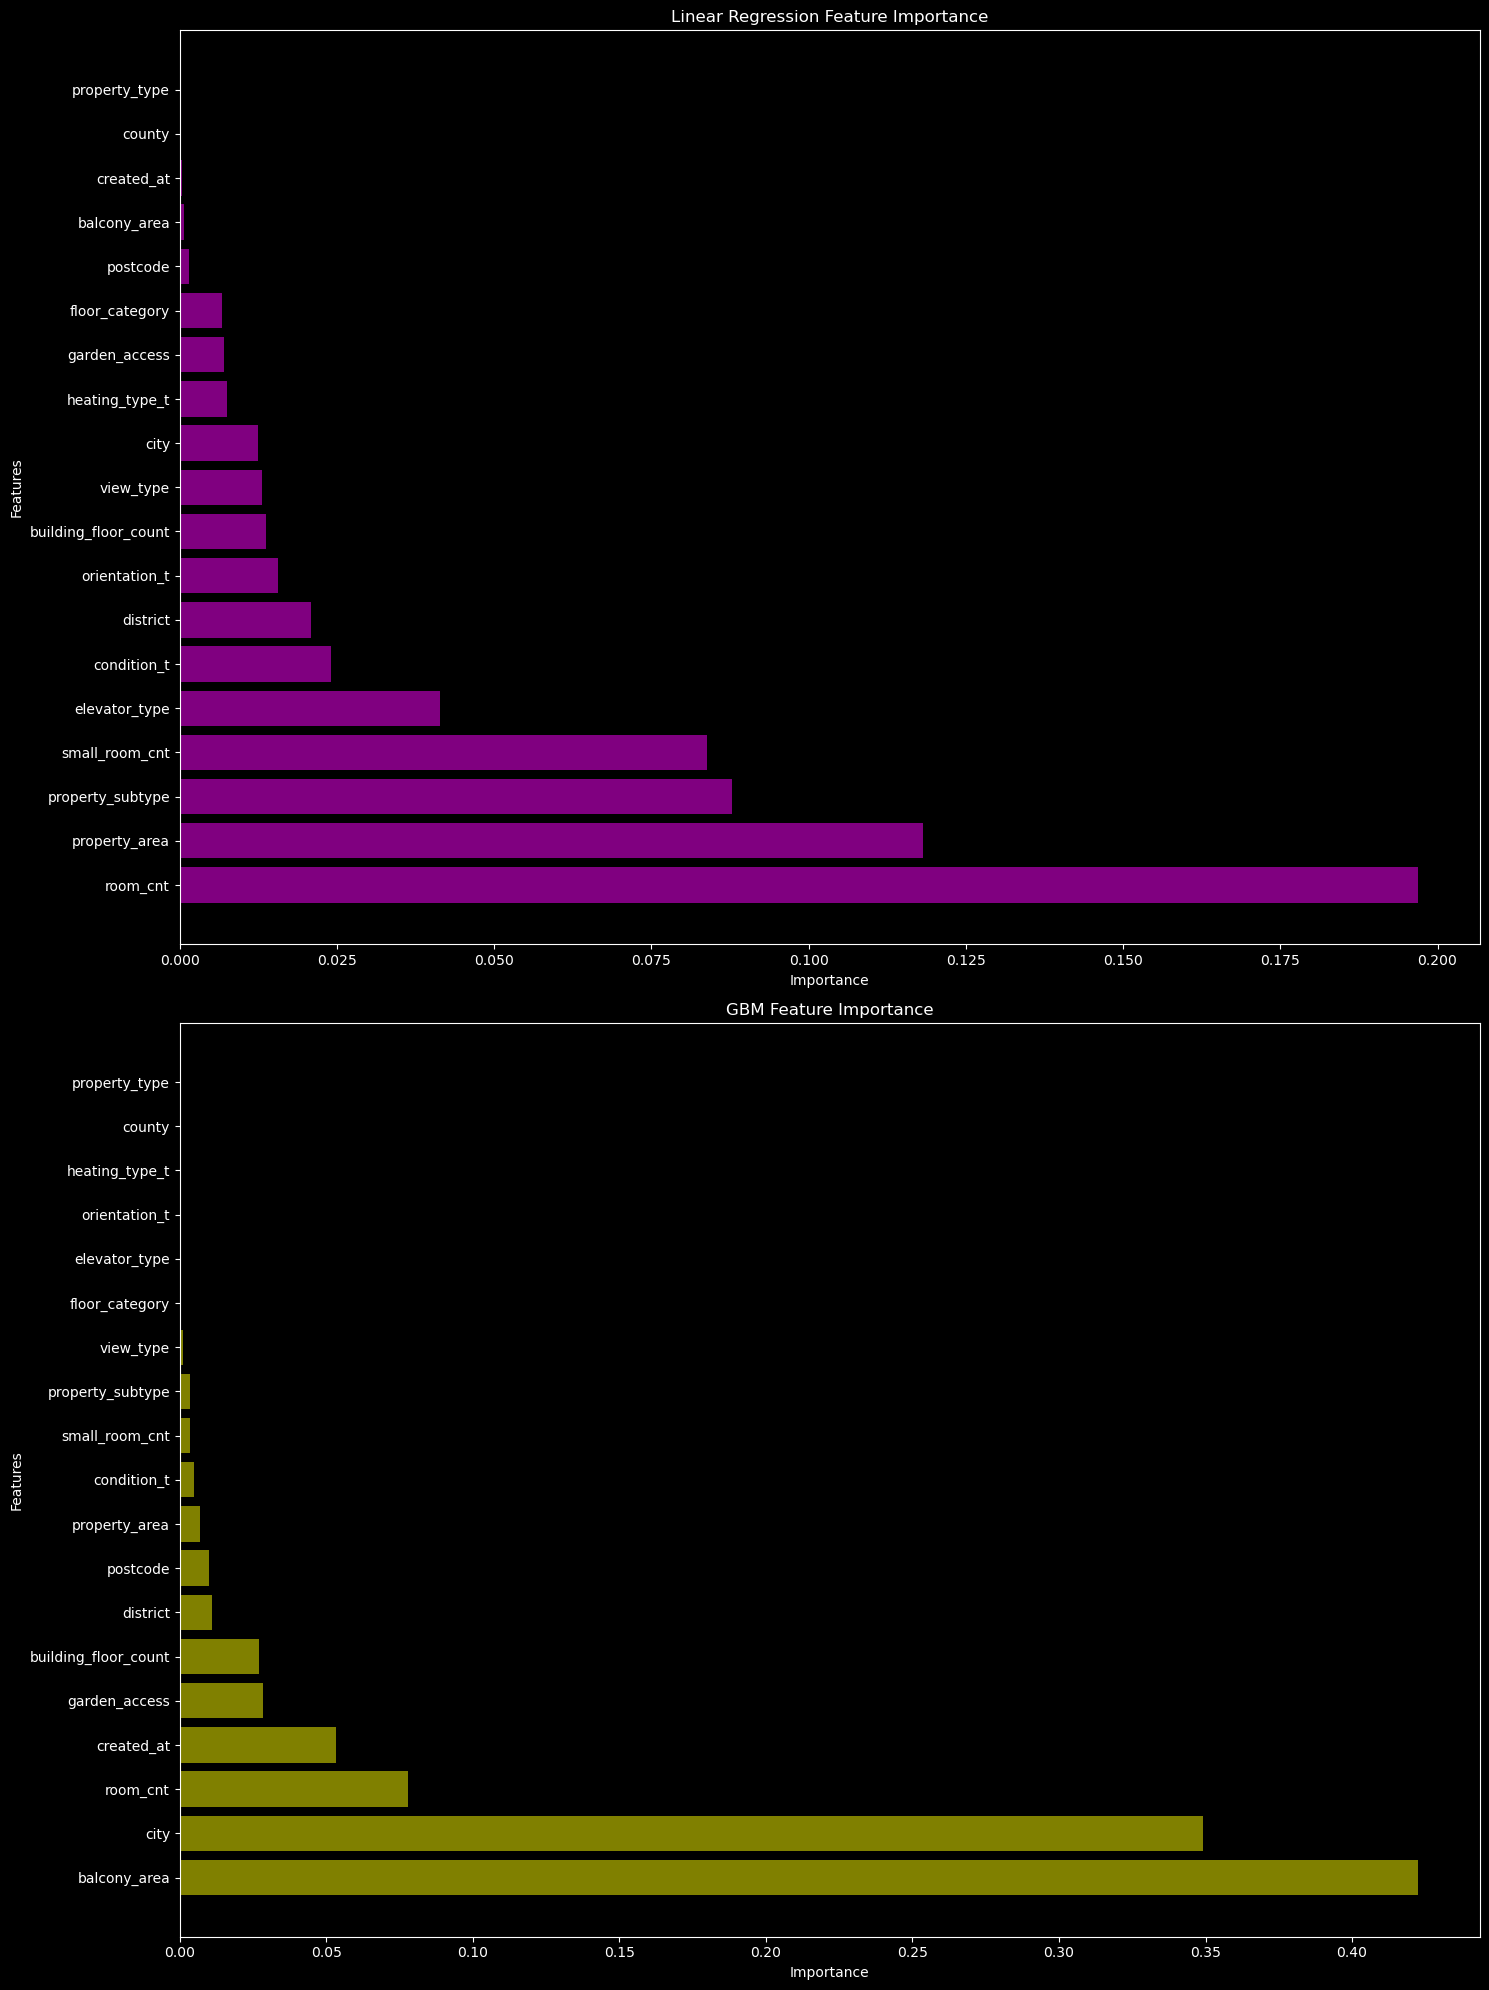

Properties undervalued by 5-25%: 40660
Percentage of total: 22.16%


In [ ]:
def feature_importance(models, features, figsize=(15, 20)):
    fig, axes = plt.subplots(len(models), 1, figsize=figsize)
    if len(models) == 1:
        axes = [axes]
    colors = {'Linear Regression': 'purple', 'GBM': 'olive'}

    for idx, (name, model) in enumerate(models.items()):
        importance = np.abs(model.coef_) if hasattr(model, 'coef_') else model.feature_importances_

        importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': importance
        }).sort_values('Importance', ascending=False)

        axes[idx].barh(importance_df['Feature'], importance_df['Importance'], color=colors.get(name, 'grey'))
        axes[idx].set_title(f"{name} Feature Importance")
        axes[idx].set_xlabel('Importance')
        axes[idx].set_ylabel('Features')

    plt.tight_layout()
    plt.show()

def save_undervalued(df, predictions, actual_prices, output_file=None):
    price_ratio = predictions / actual_prices
    undervalued_mask = (price_ratio >= 0.75) & (price_ratio <= 0.95)
    results_df = df.copy()
    results_df['predicted_price'] = predictions
    results_df['price_ratio'] = price_ratio

    undervalued_properties = results_df[undervalued_mask]

    if output_file:
        undervalued_properties.to_csv(output_file, index=False)

    undervalued_count = len(undervalued_properties)
    print(f"Properties undervalued by 5-25%: {undervalued_count}")
    print(f"Percentage of total: {(undervalued_count/len(df))*100:.2f}%")

    return undervalued_count, undervalued_properties

models = {
    'Linear Regression': lr_result.model,
    'GBM': gbm_result.model
}

all_features = numerical_features + categorical_features
feature_importance(models, all_features)

undervalued_count, undervalued_df = save_undervalued(
    df_cleaned, best_result.predictions, y, 'Results_NHVU6N.csv'
)

GBM diagramján látható hogy a balcony area teljesít a legjobban, mögötte a kerülettel, majd szobaszám, és építés éve amik mindegyike számomra logikusnak tűnnek.